Import packages and functions

In [26]:
import sys
sys.path.append('../../../')

import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scripts.utils import  rep_path, set_mpl, path2plots
import pandas as pd
import seaborn as sns
set_mpl()


sigmas_clu = np.array([0.3, 0.2, 0.1,   0.07, 0.05,
                       0.03, 0.02, 0.015, 0.01, 0.005])
f_fails_clu = np.array([0.01, 0.02, 0.05,  0.1, 0.2])


sigmas_agn = np.array([0.3, 0.2, 0.1,   0.07, 0.05,
                       0.03, 0.02, 0.015])
f_fails_agn = np.array([0.01, 0.02, 0.05,  0.1, 0.2])




%matplotlib inline
savepath = rep_path + 'results/data/BAO/'


set palette to pastel
set matplotlib rc


Load data into a data frame

In [27]:
def load_fisher_sigma0_f_fail(sigma_0, f_fail,):
    setname_clu = f'Clusters_{sigma_0}_{f_fail}'
    fname_clu = savepath + f'{setname_clu}_bao_sign.npz'

    setname_agn = f'AGN_{sigma_0}_{f_fail}'
    fname_agn = savepath + f'{setname_agn}_bao_sign.npz'

    bao_sign = []
    for fname in [fname_clu, fname_agn]:
        try:
            arr = np.load(fname, allow_pickle=True)
            bao_sign.append(np.sqrt(arr['bao_sign'])) #sqruare root of the SNR^2
        except:
            print(f'{fname} not found')
            bao_sign.append(None)
    return bao_sign



In [28]:
res_lits = []
for sigma_0 in sigmas_clu:
    for f_fail in f_fails_clu:
        bao_sign = load_fisher_sigma0_f_fail(sigma_0, f_fail)
        res_lits.append({'sigma_0': sigma_0, 'f_fail': f_fail, 'bao_sign_clu': bao_sign[0], 'bao_sign_agn': bao_sign[1]})

df_bao = pd.DataFrame(res_lits)
df_bao.head(5)

/Users/sdbykov/work/forecast_clustering/results/data/BAO/AGN_0.01_0.01_bao_sign.npz not found
/Users/sdbykov/work/forecast_clustering/results/data/BAO/AGN_0.01_0.02_bao_sign.npz not found
/Users/sdbykov/work/forecast_clustering/results/data/BAO/AGN_0.01_0.05_bao_sign.npz not found
/Users/sdbykov/work/forecast_clustering/results/data/BAO/AGN_0.01_0.1_bao_sign.npz not found
/Users/sdbykov/work/forecast_clustering/results/data/BAO/AGN_0.01_0.2_bao_sign.npz not found
/Users/sdbykov/work/forecast_clustering/results/data/BAO/AGN_0.005_0.01_bao_sign.npz not found
/Users/sdbykov/work/forecast_clustering/results/data/BAO/AGN_0.005_0.02_bao_sign.npz not found
/Users/sdbykov/work/forecast_clustering/results/data/BAO/AGN_0.005_0.05_bao_sign.npz not found
/Users/sdbykov/work/forecast_clustering/results/data/BAO/AGN_0.005_0.1_bao_sign.npz not found
/Users/sdbykov/work/forecast_clustering/results/data/BAO/AGN_0.005_0.2_bao_sign.npz not found


,sigma_0,f_fail,bao_sign_clu,bao_sign_agn
0,0.3,0.01,0.289945,1.327480
1,0.3,0.02,0.289081,1.314527
2,0.3,0.05,0.286482,1.277464
3,0.3,0.10,0.282023,1.220318
4,0.3,0.20,0.273283,1.119497


make a fucntion for interpolation on a grid

In [29]:

def bao_significance(si,fi, type = 'AGN'):
    #to compare with huetsi2014 use factor np.sqrt(1/(0.658) (to make f_sky = 1)
    if type == 'AGN':
        return df_bao.query('(f_fail == @fi) & (sigma_0 == @si)')['bao_sign_agn'].values[0]
    elif type == 'Clusters':
        return df_bao.query('(f_fail == @fi) & (sigma_0 == @si)')['bao_sign_clu'].values[0]
        


A long boring function to plots SNR as a function of `sigma_0`, `f_fail` as I want

In [30]:
set_mpl()

def plot_results(type='AGN',   cmap='GnBu'):
    if type == 'AGN':
        sigmas = sigmas_agn
        f_fails = f_fails_agn
    else:
        sigmas = sigmas_clu
        f_fails = f_fails_clu


    plt.rcParams['axes.grid'] = False

    points = []
    values = []
    for sigma_0 in sigmas:
        for f_fail in f_fails:
            points.append((sigma_0, f_fail))
            values.append(bao_significance(sigma_0, f_fail, type = type))
    
    points = np.array(points)
    values = np.array(values)

    axis_sigma = np.geomspace(sigmas.min(), sigmas.max(), 50)
    axis_f_fail = np.geomspace(f_fails.min(), f_fails.max(), 50)
    xx,yy = np.meshgrid(axis_sigma, axis_f_fail)
    result = interpolate.griddata(points, values, (xx,yy), method='linear')



    fig1 = plt.figure(figsize=(15, 10))
    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.5)
    rows, cols = 2, 5
    # (rows,cols), (y,x) <- those are coordinates of an axis in subplots
    ax = plt.subplot2grid((rows, cols), (0, 0), rowspan=2, colspan=3)
    ax_slice1 = plt.subplot2grid((rows, cols), (0, 3), rowspan=1, colspan=2)
    ax_slice2 = plt.subplot2grid((rows, cols), (1, 3), rowspan=1, colspan=2)

    im2 = ax.pcolormesh(xx, yy, result, cmap=cmap)
    cp = ax.contour(xx, yy, result, 10, colors=[
                    'k'], linestyles='-.', linewidths=2, alpha=0.5)
    ax.clabel(cp, inline=1, fontsize=15, fmt='%1.2f')
    cbar = fig1.colorbar(im2, ax=ax)
    cbar.set_label('$S/N$', rotation=90, labelpad=20)


    for f_fail in f_fails:
        sign_axis = [bao_significance(s, f_fail, type=type) for s in sigmas]

        ax_slice1.loglog(sigmas, sign_axis, '-.', lw=3,
                         alpha=0.8, label=f'{f_fail}')
        ax_slice1.set_xlabel(r'$\sigma_0$')
        ax_slice1.legend(fontsize=15, title=r'$f_{\rm fail}$', loc=(1.04, 0.4))

    for sigma in sigmas:
        sign_axis = [bao_significance(sigma, f, type=type) for f in f_fails]
        ax_slice2.semilogx(f_fails, sign_axis, '-.', lw=3,
                           alpha=0.8, label=f'{sigma}')
        ax_slice2.set_xlabel(r'$f_{\rm fail}$')
        ax_slice2.legend(fontsize=15, title=r'$\sigma_0$', loc=(1.04, 0.4))


    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\sigma_0$')
    ax.set_ylabel(r'$f_{\rm fail}$')
    ax.set_title('BAO S/N' + f', {type}; ' + r"$f_{\rm sky}$" + '=0.658')
    ax.set_xlim(0.004, 0.21)
    ax.set_ylim(0.009, 0.21)
    ax.set_xticks([0.005, 0.01, 0.02, 0.03, 0.04,
                   0.05, 0.06, 0.07, 0.1, 0.2, 0.3])
    ax.set_xticks(ax.get_xticks()[::1])


    return points, values, 





set palette to pastel
set matplotlib rc


Finally, plot the results

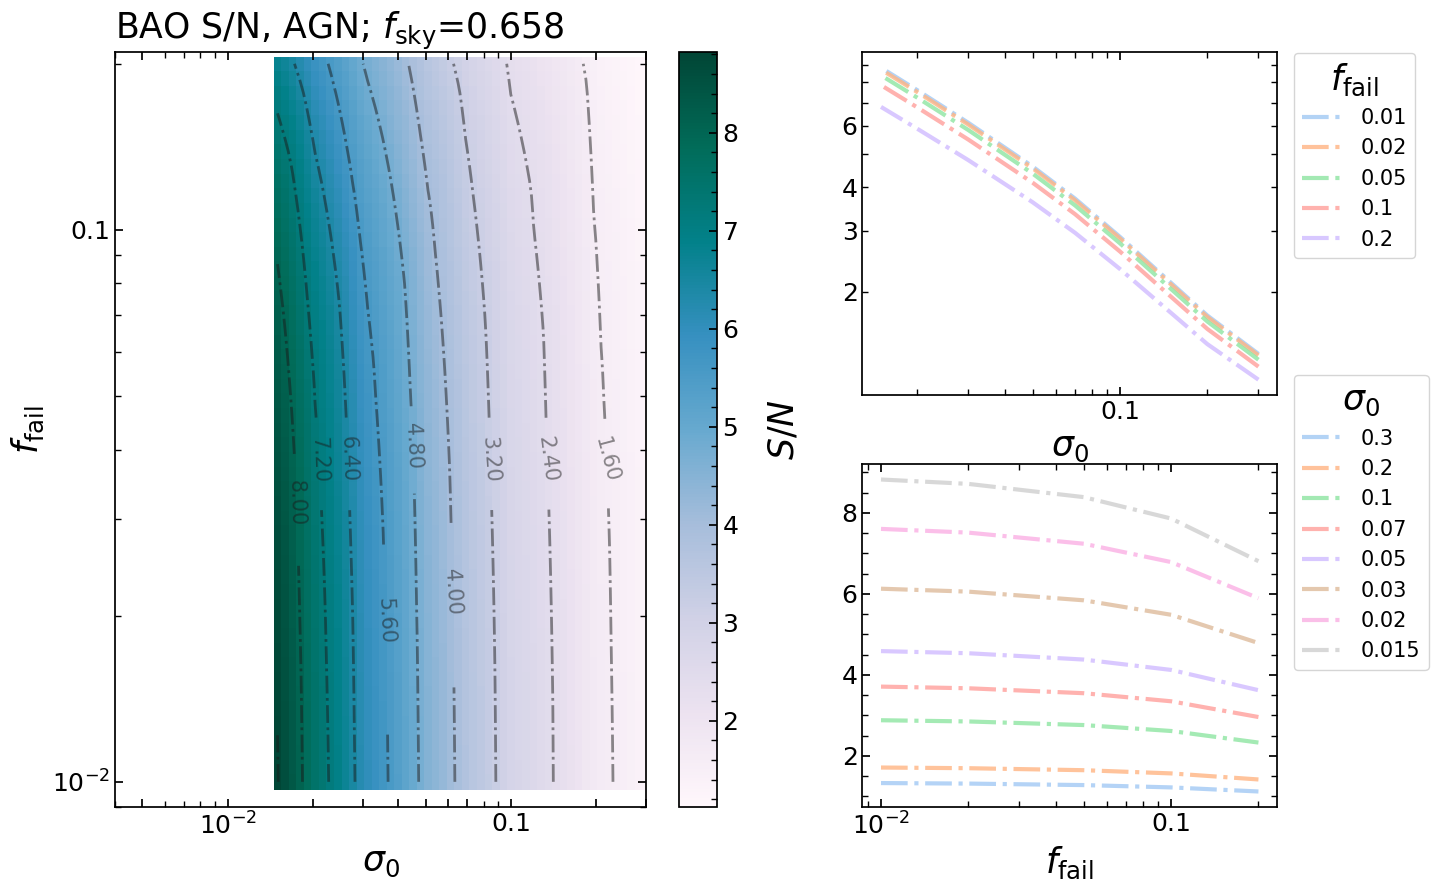

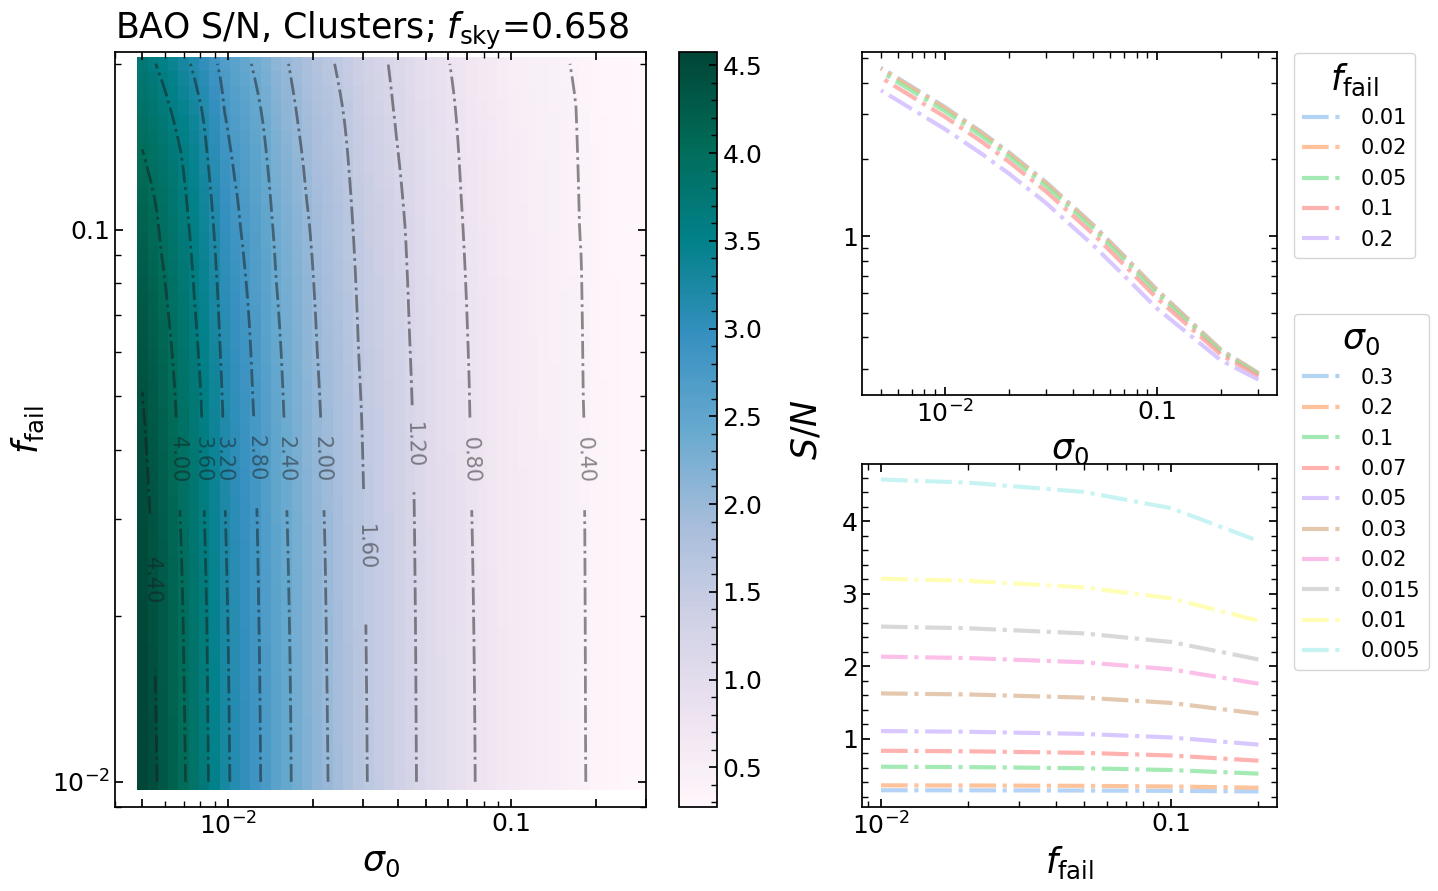

In [31]:


plot_results(type = 'AGN', cmap='PuBuGn');
plt.savefig(f'{path2plots}/bao_agn.pdf')
plot_results(type = 'Clusters', cmap='PuBuGn');
plt.savefig(f'{path2plots}/bao_clu.pdf')



Check the calculation with `0_BAO_example.ipynb` notebook:
the results for AGN was `6.126555820018136 sigma`.

In [9]:
print(np.sqrt(np.load(savepath+'/AGN_0.03_0.01_bao_sign.npz')['bao_sign']))

6.126555813404972
